## Import

In [1]:
import sys; sys.path.insert(0, '..')
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
from dataclasses import dataclass
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from keras.losses import CategoricalCrossentropy
from keras import activations
from sklearn.metrics import confusion_matrix
from utils.df_utils import df_wrapper
from utils.declarations import training_files, testing_files, POSE_MAP

## Define data

In [2]:
AMOUNT_OF_SENSORS = 3
VALIDATION_TESTSET = "004"

## Datapreparation

### Train

In [3]:
x_train_arr = []
for key in training_files:
    print(key)
    elem = df_wrapper(training_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(training_files[key].annot_file, POSE_MAP)
    x_train_arr.append(elem)

x_train = pd.concat([x.df.drop([' TimeStamp (s)', 'Pose'],axis=1) for x in x_train_arr])
y_train = pd.concat([x.df['Pose'] for x in x_train_arr])

001
..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
002
..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
003
..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

### Test

In [4]:
x_test_dict = dict()
y_test_dict = dict()
for key in testing_files:

    elem = df_wrapper(testing_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(testing_files[key].annot_file, POSE_MAP)
    y_test = elem.df["Pose"]
    y_test.index = [i for i in range(len(y_test))]
    x_test_dict[key] = elem.df
    y_test_dict[key] = y_test

x_test = x_test_dict[VALIDATION_TESTSET].drop([' TimeStamp (s)', 'Pose'], axis=1) 
y_test = y_test_dict[VALIDATION_TESTSET]

..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
..\utils\df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

## Visualisation

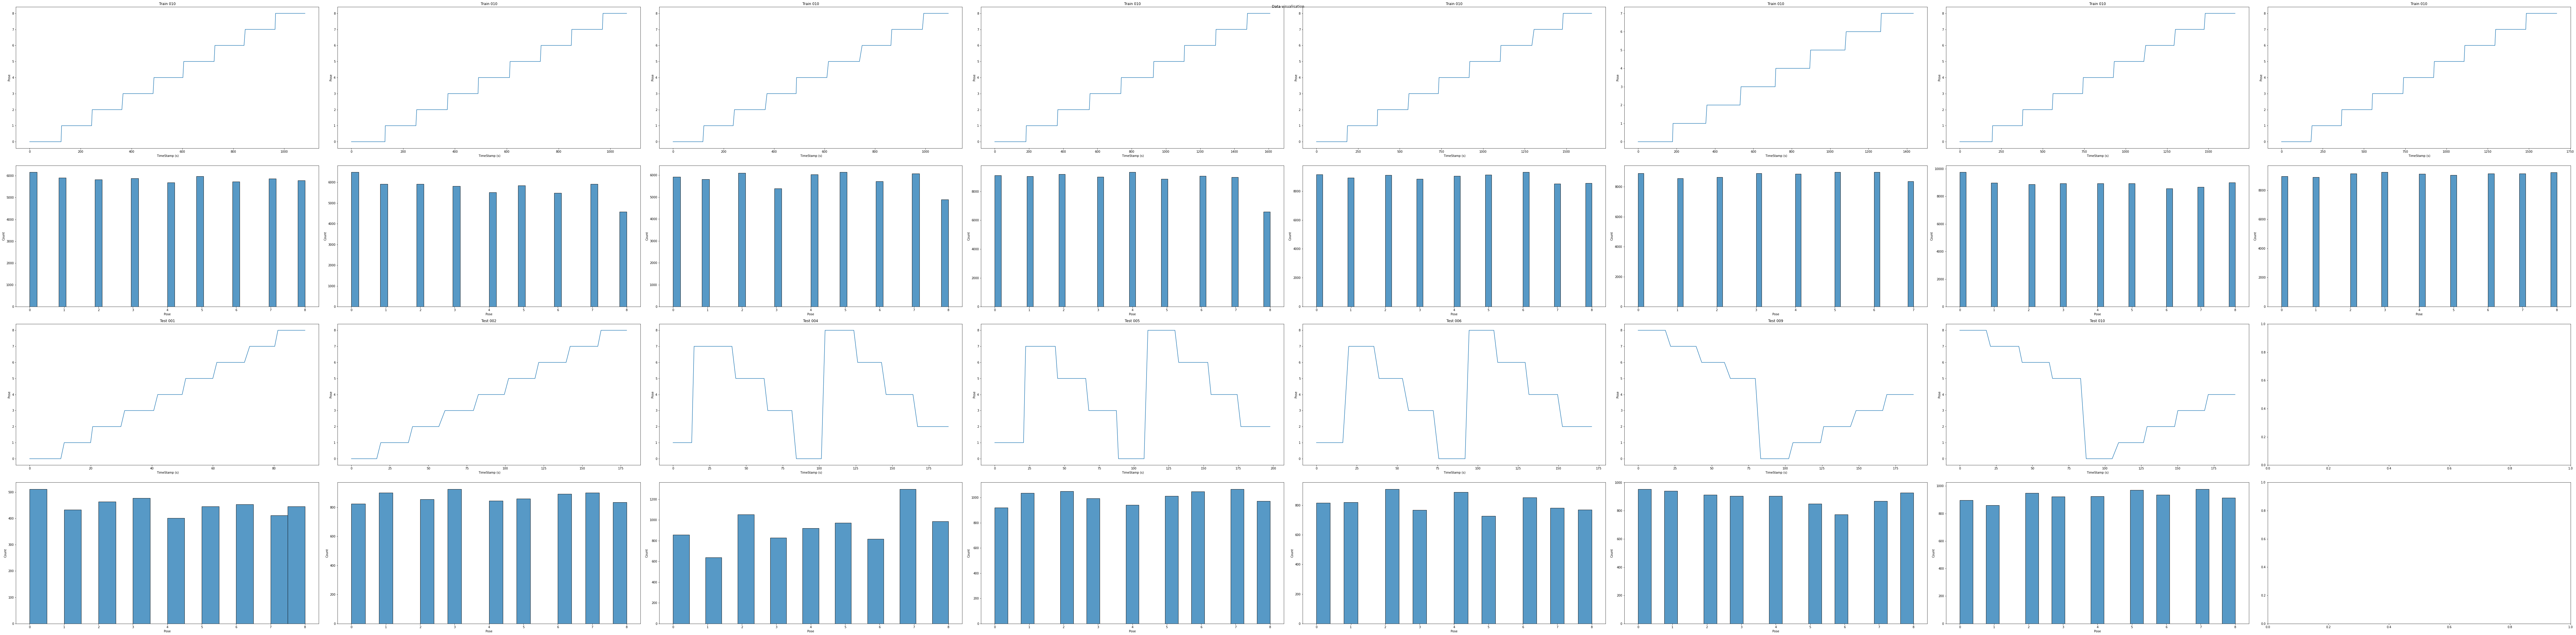

In [5]:
cols = []
height=30
width=(height/2)*len(x_train_arr)
fig, axes = plt.subplots(4, len(x_train_arr), figsize=(width, height))
fig.suptitle('Data visualisation')
# Train
for i, elem in enumerate(x_train_arr):
    sns.lineplot(ax=axes[0, i], data=elem.df, x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[1, i], data=elem.df["Pose"])
    cols.append(f'Train {key}')     
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
# Test
cols=[]
for i, key in enumerate(x_test_dict):
    sns.lineplot(ax=axes[2, i], data=x_test_dict[key], x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[3, i], data=y_test_dict[key])
    cols.append(f'Test {key}') 
for ax, col in zip(axes[2], cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

## Adjust dataframes

In [6]:
# Create numpy arrays
x_train_numpy = x_train.values
x_test_numpy = x_test.values
y_train_numpy = y_train.values
y_test_numpy = y_test.values

# Hot encode categories into numbers
y_train = to_categorical(y_train_numpy,9)
y_test = to_categorical(y_test_numpy,9)


In [7]:

print(x_train_numpy.shape)

(548854, 39)


## Hyperparams

## Model

In [30]:
import keras
from keras.layers import LSTM
from tensorflow.keras import layers

model = Sequential()
OPTIM = Adam(learning_rate=0.000001)

model = Sequential()
model.add(Dense(2048, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(700, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(300, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(9, activation='softmax'))

model.compile(optimizer=OPTIM,  loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])



## Fit the model

In [31]:
model.fit(x=x_train_numpy, y=y_train, batch_size=500, epochs=20, validation_data=(x_test_numpy, y_test), shuffle=True)

Epoch 1/20
1098/1098 [==============================] - 133s 120ms/step - loss: 4.2496 - accuracy: 0.1239 - val_loss: 2.1143 - val_accuracy: 0.2883
Epoch 2/20
1098/1098 [==============================] - 133s 121ms/step - loss: 2.4269 - accuracy: 0.1611 - val_loss: 1.9971 - val_accuracy: 0.2077
Epoch 3/20
1098/1098 [==============================] - 134s 122ms/step - loss: 2.0947 - accuracy: 0.2220 - val_loss: 1.7794 - val_accuracy: 0.3227
Epoch 4/20
1098/1098 [==============================] - 148s 135ms/step - loss: 1.8277 - accuracy: 0.3071 - val_loss: 1.5593 - val_accuracy: 0.3238
Epoch 5/20
1098/1098 [==============================] - 136s 124ms/step - loss: 1.5707 - accuracy: 0.3983 - val_loss: 1.3860 - val_accuracy: 0.3238
Epoch 6/20
1098/1098 [==============================] - 138s 126ms/step - loss: 1.3307 - accuracy: 0.4866 - val_loss: 1.2542 - val_accuracy: 0.3238
Epoch 7/20
1098/1098 [==============================] - 142s 129ms/step - loss: 1.1222 - accuracy: 0.5656 - val_

## Visualise the loss

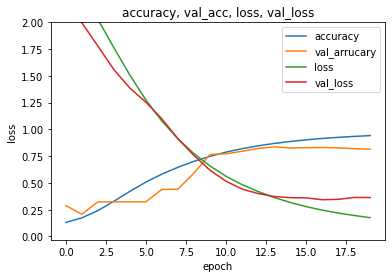

In [32]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.plot()
plt.title('accuracy, val_acc, loss, val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_arrucary', 'loss', 'val_loss'], loc='upper right')
plt.ylim(top=2)
axes=plt.gca()

plt.show()

## Precision

In [33]:
print("Classification accuracy:")
classification_dict = dict()

for key in x_test_dict:
    x_test = x_test_dict[key].drop([' TimeStamp (s)', 'Pose'], axis=1)
    classify = model.predict(x_test)
    classifications = [i.argmax() for i in classify]
    annotated_positions = y_test_dict[key].to_numpy()
    correct_classifications = (classifications == annotated_positions).sum()
    
    print(f"{key}: {round(correct_classifications/len(classifications)*100,2)}%")
    classification_dict[key] = classifications

Classification accuracy:
001: 33.2%
002: 60.21%
004: 81.57%
005: 60.51%
006: 76.2%
009: 60.89%
010: 56.09%


## Visualise classification

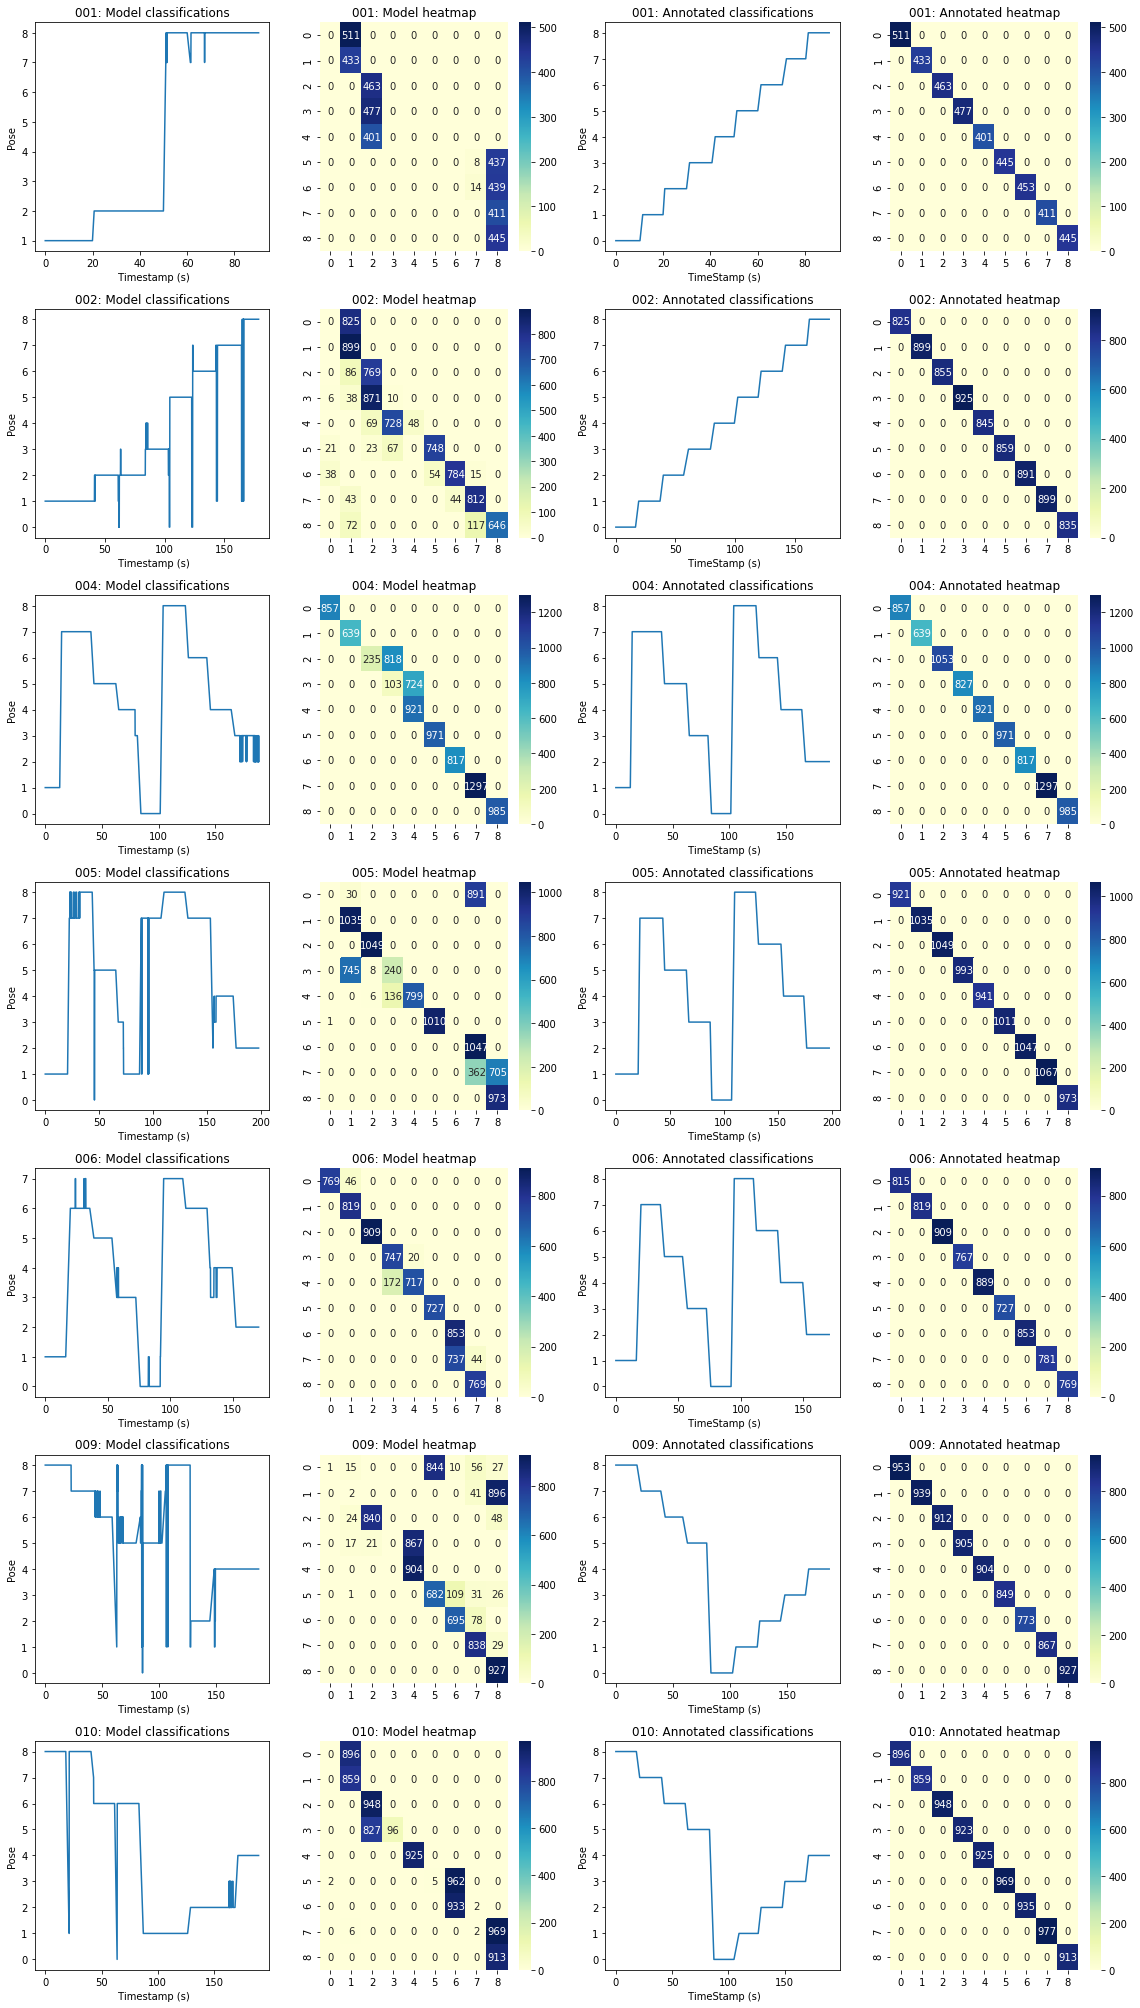

In [34]:
width=16
height=4*len(x_test_dict)
fig, axes = plt.subplots(len(x_test_dict), 4, figsize=(width, height))
for i, key in enumerate(x_test_dict):
    cols = [f"{key}: Model classifications", f"{key}: Model heatmap", f"{key}: Annotated classifications", f"{key}: Annotated heatmap"]
    df_predict = pd.DataFrame({' Timestamp (s)': x_test_dict[key][' TimeStamp (s)'],'Pose':classification_dict[key]})
    sns.lineplot(ax=axes[i, 0], data=df_predict,x=' Timestamp (s)',y='Pose')
    sns.heatmap(ax=axes[i, 1], data=confusion_matrix(y_test_dict[key], classification_dict[key]), cmap="YlGnBu", annot=True, fmt="d")
    sns.lineplot(ax=axes[i, 2], data=x_test_dict[key], x=" TimeStamp (s)", y='Pose')
    sns.heatmap(ax=axes[i, 3], data=confusion_matrix(y_test_dict[key], y_test_dict[key].to_numpy()), cmap="YlGnBu", annot=True, fmt="d")
    for ax, col in zip(axes[i], cols): ax.set_title(col)
fig.tight_layout()
plt.show()

In [35]:
"""
path = f"../models/ANN_model_{AMOUNT_OF_SENSORS}.h5"
model.save(path)
"""

'\npath = f"../models/ANN_model_{AMOUNT_OF_SENSORS}.h5"\nmodel.save(path)\n'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59d486bc-e14d-4632-9064-12272fc72d11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>